## Language Detction from documents using n-gram profiles

This notebook is an attempt at building an n-gram profile based language detector inspired by [N-gram-based text categorization Cavnar, Trenkle (1994)](https://sdmines.sdsmt.edu/upload/directory/materials/12247_20070403135416.pdf).



#### BibTex entry
```bibtex
@inproceedings{Cavnar1994NgrambasedTC,
  title={N-gram-based text categorization},
  author={William B. Cavnar and John M. Trenkle},
  year={1994},
  url={https://api.semanticscholar.org/CorpusID:170740}
}
```

### Core concept

According to the Zipf's Law, the most dominant words in a language are lesser in frequency than their more frequent yet less dominant counterparts. N-gram profiles are built on the idea of the ranking of the most prominent n-grams in a language.

Let's assume that we have a corpus $C$ of $N$ languages or categories. For each language $L$ in the $C$, we can then create the ranking of the most common n-grams, which will act as the n-gram profile, $R_l$ for $l$. Once the profiles for all languages have been computed, we can infer on a held out corpus, containing $S$ sentences. For each sentence $s$ in the corpus, we first create the n-gram profile of $s$, $R_s$. Then, we measure the distance in the rankings of the n-grams in $R_s$ against the n-gram profiles of all the languages. In the end, the language which will have the least distance is selected as the predicted result. For our prediction target $y_l$, 

$$
y_l = min(dist(R_{s_i}, [R_{L_1} , R_{L_2}, ... , R_{N}]))
$$

### Corpus

I am using this small corpus from Kaggle titled [Language Detection](https://www.kaggle.com/code/basilb2s/language-detection-using-nlp). It contains 17 languages.

In [47]:
import mlcroissant as mlc
import pandas as pd
from IPython.display import clear_output

DATASET_URL = "https://www.kaggle.com/datasets/basilb2s/language-detection/croissant/download"

def get_croissant_dataset(dataset_url: str = DATASET_URL) -> pd.DataFrame:
    # Fetch the Croissant JSON-LD
    croissant_dataset = mlc.Dataset(dataset_url)

    # Check what record sets are in the dataset
    record_sets = croissant_dataset.metadata.record_sets

    # Fetch the records and put them in a DataFrame
    df = pd.DataFrame(
        croissant_dataset.records(record_set=record_sets[0].uuid))
    
    # Rename the columns
    df.rename(columns={"Language+Detection.csv/Text": "text",
              "Language+Detection.csv/Language": "language"}, inplace=True)
    
    # convert the binary strings to utf-8
    df["text"] = df["text"].apply(lambda x: x.decode("utf-8"))
    df["language"] = df["language"].apply(lambda x: x.decode("utf-8"))
    
    # correct spelling
    spelling = {
        "Sweedish": "Swedish",
        "Portugeese": "Portuguese",     
    }
    df["language"] = df["language"].apply(lambda x: spelling.get(x, x))
        
    return df

df = get_croissant_dataset()
clear_output()

df.head()

,text,language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English


### N-gram Profiler

In [2]:
import re
from collections import Counter


class NgramProfiler:
    """
    An N-gram profiler based on the method described in the paper
    "N-Gram-Based Text Categorization" by Cavnar and Trenkle.

    This class generates a frequency profile of N-grams for a given text.
    The profile is a list of N-grams sorted in descending order of their
    occurrence frequency.

    The process involves:
    1. Tokenizing the text, keeping only alphabetic characters and apostrophes.
    2. Generating N-grams of lengths 1 to 5 for each token.
    3. Counting the frequency of each N-gram.
    4. Sorting the N-grams by frequency to create the final profile.
    """

    def __init__(self, n_min=1, n_max=5):
        """
        Initializes the NgramProfiler.

        Args:
            n_min (int): The minimum length of N-grams to generate.
            n_max (int): The maximum length of N-grams to generate.
        """
        self.n_min = n_min
        self.n_max = n_max

    def _tokenize(self, text: str) -> list[str]:
        """
        Splits text into tokens, keeping only letters and apostrophes.
        Digits and punctuation are discarded, and text is lowercased. 

        Args:
            text: The input string.

        Returns:
            A list of cleaned and lowercased tokens.
        """
        # Keep only letters and apostrophes, discard others
        text = re.sub(r'[^a-zA-Z\']+', ' ', text)
        return text.lower().split()

    def _generate_ngrams_for_token(self, token: str) -> list[str]:
        """
        Generates all possible N-grams for a single token for N=1 to 5. 
        The token is padded with spaces to handle beginning and end of words. 

        Args:
            token: A single word string.

        Returns:
            A list of all N-grams for the token.
        """
        # Pad the token with a single space on each side
        padded_token = f" {token} "
        ngrams = []
        # Scan down the token to generate N-grams from n_min to n_max
        for n in range(self.n_min, self.n_max + 1):
            for i in range(len(padded_token) - n + 1):
                ngrams.append(padded_token[i:i+n])
        return ngrams

    def generate_profile(self, text: str) -> list[str]:
        """
        Generates an N-gram frequency profile for the given text.

        The process follows the description in the paper:
        - Tokenizes the text. 
        - Generates N-grams for each token. 
        - Counts the occurrences of all N-grams. 
        - Sorts the N-grams by frequency in reverse order. 
        - Returns the list of N-grams, which constitutes the profile. 

        Args:
            text: The input document as a string.

        Returns:
            A list of N-grams sorted by frequency in descending order.
        """
        tokens = self._tokenize(text)
        all_ngrams = []
        for token in tokens:
            all_ngrams.extend(self._generate_ngrams_for_token(token))

        # Count the occurrences of all N-grams
        ngram_counts = Counter(all_ngrams)

        # Sort N-grams into reverse order by the number of occurrences
        sorted_ngrams = sorted(ngram_counts.keys(),
                               key=lambda x: ngram_counts[x], reverse=True)

        return sorted_ngrams

### Out of place distance function

In [3]:
def calculate_distance(doc_profile: list[str], category_profile: list[str], no_match_penalty: int | None = None) -> int:
    """
    Calculates the 'out-of-place' distance between two N-gram profiles.

    This measure is based on the description in "N-Gram-Based Text Categorization".
    It computes how far out of place N-grams in the document profile are
    compared to their positions in the category profile.

    Args:
        doc_profile: A list of N-grams for the document, sorted by frequency.
        category_profile: A list of N-grams for the category, sorted by frequency.
        no_match_penalty: The penalty to apply for an N-gram in the document
                          profile that is not found in the category profile.
                          If None, it defaults to the length of the category profile.

    Returns:
        The total out-of-place distance between the two profiles.
    """
    # Create a map of N-gram to rank for the category profile for efficient lookup
    category_ranks = {ngram: i for i, ngram in enumerate(category_profile)}

    # Set the penalty for N-grams not found in the category profile.
    # The paper suggests a "maximum out-of-place value". The length of the
    # profile is a reasonable choice for this maximum penalty.
    if no_match_penalty is None:
        no_match_penalty = len(category_profile)

    total_distance = 0

    # Iterate through the document profile to calculate the distance
    for doc_rank, ngram in enumerate(doc_profile):
        if ngram in category_ranks:
            category_rank = category_ranks[ngram]
            # Calculate how far out of place the N-gram is
            distance = abs(doc_rank - category_rank)
        else:
            # Apply penalty if the N-gram is not in the category profile
            distance = no_match_penalty
        total_distance += distance

    return total_distance

### Train-Test Splits

In [4]:
from sklearn.model_selection import train_test_split

texts, languages = df["text"], df["language"]
train_texts, test_texts, train_languages, test_languages = train_test_split(texts, languages, test_size=0.2, random_state=42)

assert len(train_texts) == len(train_languages)
assert len(test_texts) == len(test_languages)

### Language Classifier

In [5]:
from tqdm.auto import tqdm
from typing import Callable


class DocumentClassifier:
    def __init__(self, profiler: NgramProfiler, profile_size: int, distance_fn: Callable):
        self.profiler = profiler
        self.profile_size = profile_size
        self.distance_fn = distance_fn
        
        self.profiles = {}
        
    def fit(self, docs: list[str], languages: list[str]):
        data_dict = {lang : [] for lang in languages}
        # collect all texts for one language
        for doc, language in tqdm(zip(docs, languages), total=len(docs)):
            if language not in data_dict:
                data_dict[language] = [doc]
            else:
                data_dict[language].append(doc)
        
        # generate profiles
        for category in data_dict.keys():
            text = " ".join(data_dict[category])
            profile = self.profiler.generate_profile(text)
            self.profiles[category] = profile[:self.profile_size]
        
    def predict(self, doc: str):
        doc_profile = self.profiler.generate_profile(doc)
        
        category_distances = {}
        for category in self.profiles.keys():
            distance = self.distance_fn(doc_profile, self.profiles[category])
            category_distances[category] = distance
            
        return min(category_distances, key=category_distances.get)
        


### Inference

In [60]:
def infer(clf: DocumentClassifier, docs: list[str]) -> list[str]:
    """Infer the language of the docs"""
    
    predictions = []
    for _, doc in tqdm(enumerate(docs), total=len(docs)):
        predictions.append(clf.predict(doc))
        
    return predictions

### Evaluation

Since this is a classification task, I am using the usual accuracy, precision, recall and f1-score as metric.

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


def evaluate(predictions: list[str], labels: list[str]) -> tuple[float, float, float, float, str]:
    """Evaluate the predictions"""
    accuracy = accuracy_score(predictions, labels)
    precision = precision_score(predictions, labels, average='macro')
    recall = recall_score(predictions, labels, average='macro')
    f1 = f1_score(predictions, labels, average='macro')
    
    # also get the classification report
    report = classification_report(predictions, labels)

    return accuracy, precision, recall, f1, report

### Train and Eval

In [28]:
classifier = DocumentClassifier(
    profiler=NgramProfiler(), 
    profile_size=200, 
    distance_fn=calculate_distance
)

In [29]:
classifier.fit(train_texts, train_languages)

In [36]:
predictions = infer(classifier, test_texts)

In [44]:
accuracy, precision, recall, f1, report = evaluate(predictions, test_languages)

print(report)

              precision    recall  f1-score   support

      Arabic       0.02      0.29      0.04         7
      Danish       0.84      0.84      0.84        73
       Dutch       0.87      0.94      0.91       103
     English       0.86      0.93      0.89       269
      French       0.81      0.93      0.87       191
      German       0.92      0.92      0.92        93
       Greek       0.88      0.11      0.20       531
       Hindi       0.20      0.12      0.15        17
     Italian       0.77      0.87      0.82       127
     Kannada       0.05      0.18      0.07        17
   Malayalam       0.00      0.00      0.00         5
  Portuguese       0.90      0.80      0.85       163
     Russian       0.01      0.03      0.02        58
     Spanish       0.86      0.85      0.85       163
     Swedish       0.85      0.88      0.86       129
       Tamil       0.00      0.00      0.00         9
     Turkish       0.94      0.88      0.91       113

    accuracy              

## Anaylsis

Although this model performs well for English and languages with similar typography, it performs poorly for others, specifically, Russian, Greek, Tamil, Hindi, Arabic, Malaylam and Kannada. The primary reason behind this can be that the ngrams are created from characters and not words. 

However, there is one hyperparameter, which may affect the overall performance of the classifier and that is `profile_size`, which dictates how many of the ranked ngrams should be used to calculate the distance between a document profile and a category or language profile.

### Profile Size vs Metrics plots

In [54]:
import matplotlib.pyplot as plt


profile_sizes = [50, 100, 200, 300, 400]


def explore_profile_size(
    test_texts: list[str] = test_texts,
    test_languages: list[str] = test_languages,
    train_texts: list[str] = train_texts,
    train_labels: list[str] = train_languages,
    profile_sizes: list[int] = profile_sizes,
    distance_fn: Callable = calculate_distance
) -> None:
    f1_scores = []
    accuracies = []
    precisions = []
    recalls = []
    
    for profile_size in profile_sizes:
        classifier = DocumentClassifier(
            profiler=NgramProfiler(), 
            profile_size=profile_size, 
            distance_fn=calculate_distance
        )
        
        classifier.fit(train_texts, train_languages)
        
        predictions = infer(classifier, test_texts)
        accuracy, precision, recall, f1, _ = evaluate(predictions, test_languages)
        
        f1_scores.append(f1)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        
        clear_output()


    plt.plot(profile_sizes, f1_scores, label="F1 Score")
    plt.plot(profile_sizes, accuracies, label="Accuracy")
    plt.plot(profile_sizes, precisions, label="Precision")
    plt.plot(profile_sizes, recalls, label="Recall")
    plt.legend()
    plt.show()
    

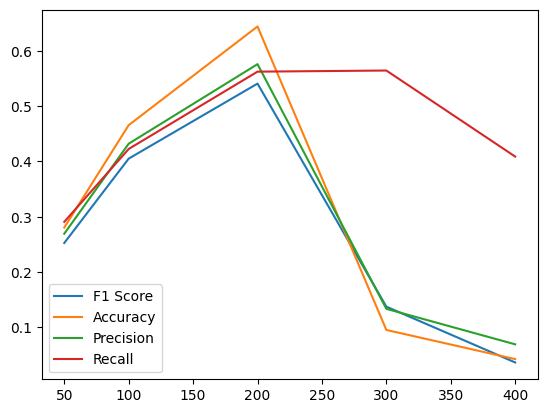

In [55]:
explore_profile_size()

On the current corpus, a profile size around 200 yields the best performance for all the metrics. Recall however, maintains a stable position till around 300 after which it gradually drops. Other metrics show sharp descent right after 200. 

Let's pick 3 languages and repeat the same experiment.

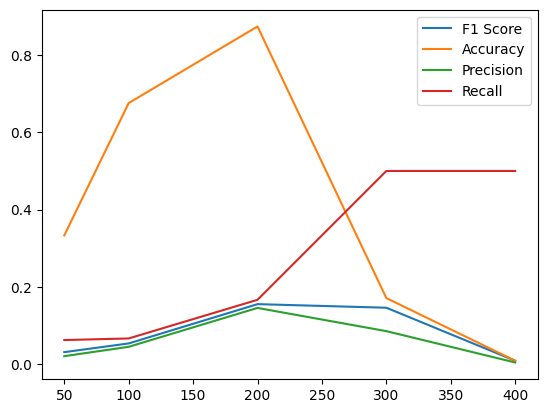

In [57]:
# Dutch

# collect all test data for dutch
dutch_test_texts = [text for text, language in zip(test_texts, test_languages) if language == "Dutch"]
dutch = ["Dutch"] * len(dutch_test_texts)


explore_profile_size(
    test_texts=dutch_test_texts,
    test_languages=dutch,
)

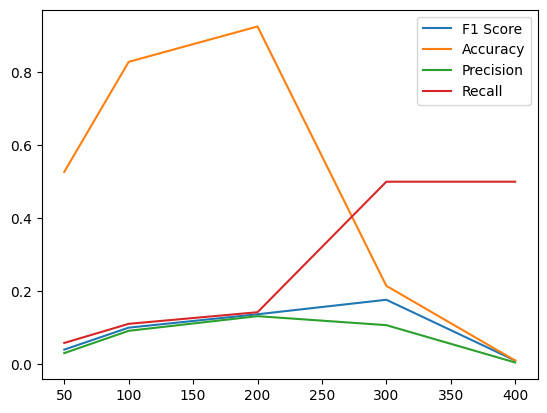

In [58]:
# German

german_test_texts = [text for text, language in zip(test_texts, test_languages) if language == "German"]
german = ["German"] * len(german_test_texts)

explore_profile_size(
    test_texts=german_test_texts,
    test_languages=german,
)

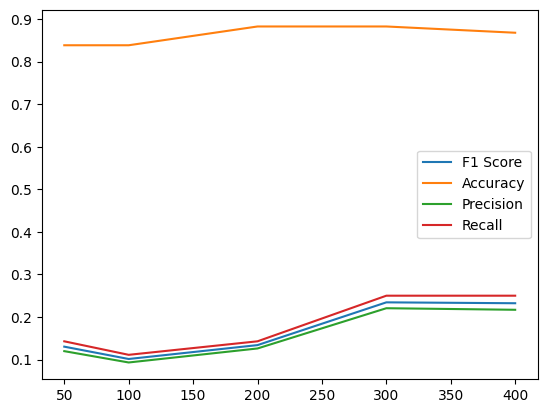

In [59]:
# Greek
greek_test_texts = [text for text, language in zip(test_texts, test_languages) if language == "Greek"]
greek = ["Greek"] * len(greek_test_texts)

explore_profile_size(
    test_texts=greek_test_texts,
    test_languages=greek,
)

All languages show higher accuracy throughout the profile sizes yet their recall and precision and in turn f1 score falter. This is not extraordinary as accuracy can be easily fooled by making false positives and false negatives to 0 and hence not a very reliable metric to judge the quality of a classifier. 